# import libarary

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import glob
from sklearn.utils import shuffle
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from catboost import Pool, CatBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
# from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
import time

import pickle

### read df_train

In [2]:
df = pd.read_csv('../data/raw/df_train.csv' , encoding='cp1252')

In [3]:
df.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.3-192.168.10.16-53-45506-17,192.168.10.16,45506.0,192.168.10.3,53.0,17.0,7/7/2017 10:55,31087.0,2.0,2.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,172.16.0.1-192.168.10.50-46298-80-6,172.16.0.1,46298.0,192.168.10.50,80.0,6.0,5/7/2017 10:44,98335726.0,8.0,5.0,...,32.0,1008.0,0.0,1008.0,1008.0,98300000.0,0.0,98300000.0,98300000.0,1
2,192.168.10.3-192.168.10.5-53-63360-17,192.168.10.5,63360.0,192.168.10.3,53.0,17.0,7/7/2017 11:51,222.0,2.0,2.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,192.168.10.5-23.61.187.27-50113-80-6,23.61.187.27,80.0,192.168.10.5,50113.0,6.0,03/07/2017 03:34:29,66.0,1.0,1.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,172.16.0.1-192.168.10.50-44526-80-6,172.16.0.1,44526.0,192.168.10.50,80.0,6.0,5/7/2017 10:58,4.0,2.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [4]:
def preprossening_all(df , im_feature):
    df_new = df.drop(['Bwd PSH Flags' ,'Bwd URG Flags', 'Fwd Avg Bytes/Bulk' , 'Fwd Avg Packets/Bulk',
                        'Bwd Avg Bytes/Bulk' , 'Bwd Avg Packets/Bulk',
                          'Flow ID', 'Source IP', 'Source Port',
                           'Destination IP', 'Destination Port', 
                          'Protocol', 'Timestamp','Fwd Avg Bulk Rate', 'Bwd Avg Bulk Rate'], axis=1)
    
    df_clean = df_new.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
   
    
    df_im = df_clean[im_feature]
    df_im['Label'] = df_clean.Label
    
    return df_im 
    

In [5]:
im_feature = ['PSH Flag Count','Init_Win_bytes_forward','Bwd Packet Length Std','Avg Bwd Segment Size',
                'Bwd Packet Length Max','Packet Length Variance','Bwd Packet Length Mean','Bwd Packet Length Min','Packet Length Std',
                'min_seg_size_forward','Average Packet Size','Flow IAT Max','Fwd IAT Std','Idle Min','Packet Length Mean',
                  'Fwd IAT Max','Idle Max','ACK Flag Count','Flow IAT Std','URG Flag Count']

In [6]:
df_final = preprossening_all(df, im_feature)

C:\Users\Ekhlas\AppData\Local\Temp\ipykernel_11936\2919573445.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_im['Label'] = df_clean.Label


In [16]:
df_final

,PSH Flag Count,Init_Win_bytes_forward,Bwd Packet Length Std,Avg Bwd Segment Size,Bwd Packet Length Max,Packet Length Variance,Bwd Packet Length Mean,Bwd Packet Length Min,Packet Length Std,min_seg_size_forward,...,Flow IAT Max,Fwd IAT Std,Idle Min,Packet Length Mean,Fwd IAT Max,Idle Max,ACK Flag Count,Flow IAT Std,URG Flag Count,Label
0,0.0,-1.0,0.00000,112.0,112.0,1968.300,112.0,112.0,44.365527,32.0,...,31027.0,0.0,0.0,63.400000,11.0,0.0,0.0,1.789614e+04,0.0,0
1,0.0,274.0,4420.67608,2319.0,10147.0,7307326.181,2319.0,0.0,2703.206648,32.0,...,98300000.0,37200000.0,98300000.0,852.785714,98300000.0,98300000.0,1.0,2.840000e+07,0.0,1
2,0.0,-1.0,0.00000,166.0,166.0,4915.200,166.0,166.0,70.108487,32.0,...,216.0,0.0,0.0,89.200000,3.0,0.0,0.0,1.229756e+02,0.0,0
3,0.0,913.0,0.00000,6.0,6.0,0.000,6.0,6.0,0.000000,20.0,...,66.0,0.0,0.0,6.000000,0.0,0.0,1.0,0.000000e+00,1.0,0
4,0.0,274.0,0.00000,0.0,0.0,0.000,0.0,0.0,0.000000,32.0,...,4.0,0.0,0.0,0.000000,4.0,0.0,1.0,0.000000e+00,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3119339,0.0,296.0,0.00000,0.0,0.0,0.000,0.0,0.0,0.000000,32.0,...,3.0,0.0,0.0,0.000000,3.0,0.0,1.0,0.000000e+00,0.0,1
3119340,0.0,-1.0,0.00000,51.0,51.0,76.800,51.0,51.0,8.763561,32.0,...,173.0,0.0,0.0,41.400000,1.0,0.0,0.0,8.889882e+01,0.0,0
3119341,0.0,-1.0,0.00000,122.0,122.0,2352.000,122.0,122.0,48.497423,20.0,...,30445.0,0.0,0.0,66.000000,0.0,0.0,0.0,0.000000e+00,0.0,0
3119343,0.0,274.0,0.00000,0.0,0.0,0.000,0.0,0.0,0.000000,32.0,...,998.0,0.0,0.0,0.000000,998.0,0.0,1.0,0.000000e+00,0.0,1


In [8]:
sampledf = df_final.sample(n=50000,random_state=42)

# functions


## Split

In [9]:
X = sampledf.iloc[:,:-1]
y = sampledf.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

## Modeling

In [10]:


def model_metrics(model, X_train, X_valid, y_train, y_valid):
    time1 = time.time()
#     model = RandomForestClassifier(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    print('Training Time:', time.time() - time1)
        
    time2 = time.time()
    preds = model.predict(X_valid)
    print('validation Time:', time.time() - time2)
        
    calculate_metrics(y_valid, preds)
    print()
    print(classification_report(y_test, preds))
    print()
#     confusion_matrix = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(confusion_matrix(y_test, preds), display_labels = model.classes_).plot()
    print()
    return model

def calculate_metrics(y_true, y_pred):
    print()
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred))
    print('Recall:', recall_score(y_true, y_pred))
    print('f1 score:', f1_score(y_true, y_pred))
    print()
    


### random forst classifier

In [14]:

rf_model = RandomForestClassifier(n_estimators=100, random_state=0)

Training Time: 2.504460096359253
validation Time: 0.10937309265136719

Accuracy: 0.9961333333333333
Precision: 0.9909487093530004
Recall: 0.9896216940073652
f1 score: 0.9902847571189279


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12013
           1       0.99      0.99      0.99      2987

    accuracy                           1.00     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       1.00      1.00      1.00     15000





RandomForestClassifier(random_state=0)

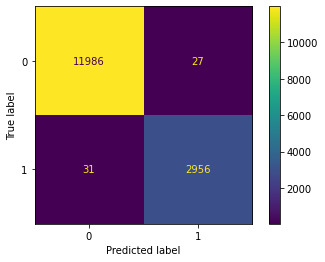

In [15]:
model_metrics(rf_model, X_train, X_test, y_train, y_test)

### GaussianNB

In [17]:

gnb_model = GaussianNB()

Training Time: 0.018001794815063477
validation Time: 0.008030891418457031

Accuracy: 0.8522
Precision: 0.7024185068349106
Recall: 0.4472715098761299
f1 score: 0.5465330333401515


              precision    recall  f1-score   support

           0       0.87      0.95      0.91     12013
           1       0.70      0.45      0.55      2987

    accuracy                           0.85     15000
   macro avg       0.79      0.70      0.73     15000
weighted avg       0.84      0.85      0.84     15000





GaussianNB()

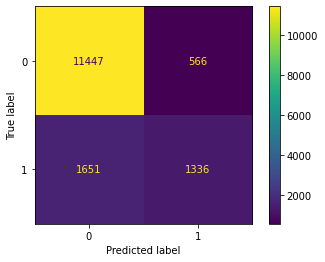

In [18]:
model_metrics(gnb_model, X_train, X_test, y_train, y_test)

### BaggingClassifier on gnb

Training Time: 0.27309250831604004
validation Time: 0.031249523162841797

Accuracy: 0.8502
Precision: 0.6911157024793388
Recall: 0.44794107800468697
f1 score: 0.5435709932967703


              precision    recall  f1-score   support

           0       0.87      0.95      0.91     12013
           1       0.69      0.45      0.54      2987

    accuracy                           0.85     15000
   macro avg       0.78      0.70      0.73     15000
weighted avg       0.84      0.85      0.84     15000





BaggingClassifier(base_estimator=GaussianNB(), max_features=0.5,
                  max_samples=0.5)

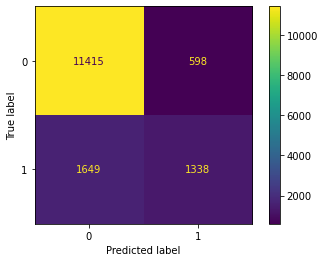

In [19]:

bagging_gnb_model = BaggingClassifier(gnb_model,
                            max_samples=0.5, max_features=0.5)
model_metrics(bagging_gnb_model, X_train, X_test, y_train, y_test)

### ada boost classifier on GNB

Training Time: 2.18595814704895
validation Time: 0.37162065505981445

Accuracy: 0.2876666666666667
Precision: 0.126238104486308
Recall: 0.43521928356210243
f1 score: 0.19570944674444865


              precision    recall  f1-score   support

           0       0.64      0.25      0.36     12013
           1       0.13      0.44      0.20      2987

    accuracy                           0.29     15000
   macro avg       0.38      0.34      0.28     15000
weighted avg       0.54      0.29      0.33     15000





AdaBoostClassifier(base_estimator=GaussianNB(), random_state=0)

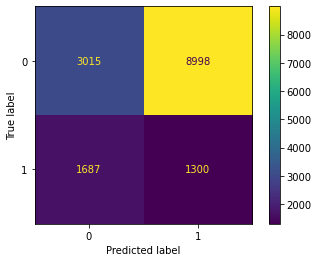

In [21]:

boost_gnb_model = AdaBoostClassifier(base_estimator=gnb_model, n_estimators=50, random_state=0)
model_metrics(boost_gnb_model, X_train, X_test, y_train, y_test)

### KNN CLASSIFIER

Training Time: 0.0040013790130615234
validation Time: 10.024909019470215

Accuracy: 0.9812666666666666
Precision: 0.941579634464752
Recall: 0.9658520254435888
f1 score: 0.9535613948107751


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     12013
           1       0.94      0.97      0.95      2987

    accuracy                           0.98     15000
   macro avg       0.97      0.98      0.97     15000
weighted avg       0.98      0.98      0.98     15000





KNeighborsClassifier()

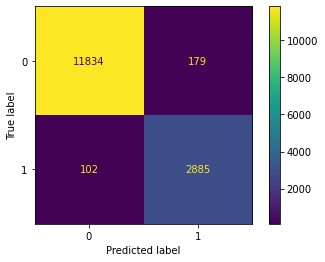

In [23]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5)
model_metrics(knn_model, X_train, X_test, y_train, y_test)

### bagging on KNN

Training Time: 0.6224238872528076
validation Time: 2.0630457401275635

Accuracy: 0.9798
Precision: 0.9586466165413534
Recall: 0.9390693003013056
f1 score: 0.9487569761542365


              precision    recall  f1-score   support

           0       0.98      0.99      0.99     12013
           1       0.96      0.94      0.95      2987

    accuracy                           0.98     15000
   macro avg       0.97      0.96      0.97     15000
weighted avg       0.98      0.98      0.98     15000





BaggingClassifier(base_estimator=KNeighborsClassifier(), max_features=0.5,
                  max_samples=0.5)

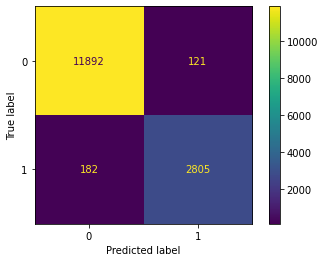

In [24]:
from sklearn.ensemble import BaggingClassifier
bagging_knn_model = BaggingClassifier(knn_model,
                            max_samples=0.5, max_features=0.5)
model_metrics(bagging_knn_model, X_train, X_test, y_train, y_test)

### decision tree classifier

Training Time: 0.18389081954956055
validation Time: 0.0

Accuracy: 0.9947333333333334
Precision: 0.9836992681304059
Recall: 0.9899564780716438
f1 score: 0.9868179542799933


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12013
           1       0.98      0.99      0.99      2987

    accuracy                           0.99     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       0.99      0.99      0.99     15000





DecisionTreeClassifier()

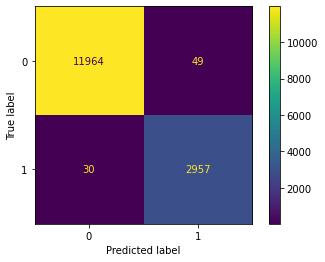

In [25]:
from sklearn import tree
tree_model = tree.DecisionTreeClassifier()
model_metrics(tree_model, X_train, X_test, y_train, y_test)

### bagging on decision tree

Training Time: 0.36179637908935547
validation Time: 0.01563262939453125

Accuracy: 0.9937333333333334
Precision: 0.9911714770797962
Recall: 0.9772346836290593
f1 score: 0.9841537424140258


              precision    recall  f1-score   support

           0       0.99      1.00      1.00     12013
           1       0.99      0.98      0.98      2987

    accuracy                           0.99     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       0.99      0.99      0.99     15000





BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_features=0.5,
                  max_samples=0.5)

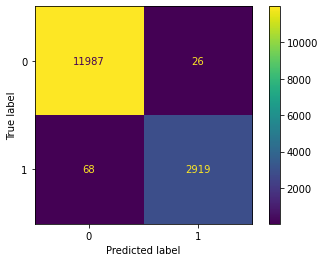

In [26]:
from sklearn.ensemble import BaggingClassifier
bagging_tree_model = BaggingClassifier(tree_model,
                            max_samples=0.5, max_features=0.5)
model_metrics(bagging_tree_model, X_train, X_test, y_train, y_test)

### ada boost on decition tree

Training Time: 6.337043762207031
validation Time: 0.10938072204589844

Accuracy: 0.9964
Precision: 0.990304246071548
Recall: 0.9916303983930365
f1 score: 0.9909668785547006


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12013
           1       0.99      0.99      0.99      2987

    accuracy                           1.00     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       1.00      1.00      1.00     15000





AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=0)

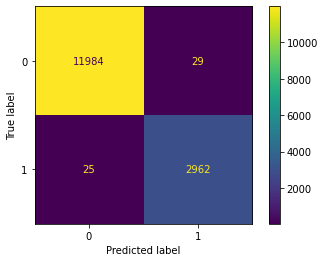

In [27]:

boost_tree_model = AdaBoostClassifier(base_estimator=tree_model, n_estimators=50, random_state=0)
model_metrics(boost_tree_model, X_train, X_test, y_train, y_test)

### logistic regration


Training Time: 0.4729607105255127
validation Time: 0.0

Accuracy: 0.8214666666666667
Precision: 0.5629841011006931
Recall: 0.4623367927686642
f1 score: 0.5077205882352941


              precision    recall  f1-score   support

           0       0.87      0.91      0.89     12013
           1       0.56      0.46      0.51      2987

    accuracy                           0.82     15000
   macro avg       0.72      0.69      0.70     15000
weighted avg       0.81      0.82      0.81     15000





C:\Users\Ekhlas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

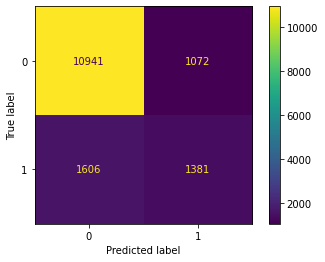

In [28]:
# max_iter=100

lg_model = LogisticRegression(max_iter=100, random_state=0)
model_metrics(lg_model, X_train, X_test, y_train, y_test)

### bagging on logistig

Training Time: 0.859339714050293
validation Time: 0.015970230102539062

Accuracy: 0.5839333333333333
Precision: 0.21714186369958274
Recall: 0.4181452962838969
f1 score: 0.2858450623641149


              precision    recall  f1-score   support

           0       0.81      0.63      0.71     12013
           1       0.22      0.42      0.29      2987

    accuracy                           0.58     15000
   macro avg       0.51      0.52      0.50     15000
weighted avg       0.69      0.58      0.62     15000





BaggingClassifier(base_estimator=LogisticRegression(random_state=0),
                  max_features=0.5, max_samples=0.5)

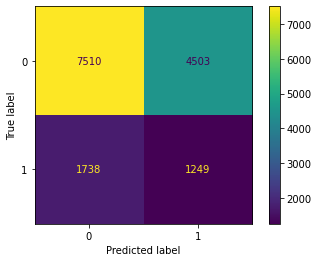

In [29]:

bagging_lg_model = BaggingClassifier(lg_model,
                            max_samples=0.5, max_features=0.5)
model_metrics(bagging_lg_model, X_train, X_test, y_train, y_test)

C:\Users\Ekhlas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Ekhlas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

Training Time: 2.8217122554779053
validation Time: 0.0650022029876709

Accuracy: 0.8386666666666667
Precision: 0.6393120393120393
Recall: 0.435554067626381
f1 score: 0.5181202708084429


              precision    recall  f1-score   support

           0       0.87      0.94      0.90     12013
           1       0.64      0.44      0.52      2987

    accuracy                           0.84     15000
   macro avg       0.75      0.69      0.71     15000
weighted avg       0.82      0.84      0.83     15000





AdaBoostClassifier(base_estimator=LogisticRegression(random_state=0),
                   random_state=0)

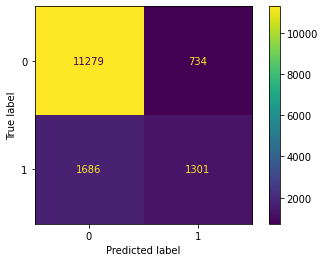

In [30]:

boost_lg_model = AdaBoostClassifier(base_estimator=lg_model, n_estimators=50, random_state=0)
model_metrics(boost_lg_model, X_train, X_test, y_train, y_test)

### perceptron

Training Time: 0.15588831901550293
validation Time: 0.0

Accuracy: 0.7454666666666667
Precision: 0.3256399496433068
Recall: 0.2597924338801473
f1 score: 0.28901303538175044


              precision    recall  f1-score   support

           0       0.82      0.87      0.84     12013
           1       0.33      0.26      0.29      2987

    accuracy                           0.75     15000
   macro avg       0.58      0.56      0.57     15000
weighted avg       0.73      0.75      0.73     15000





Perceptron()

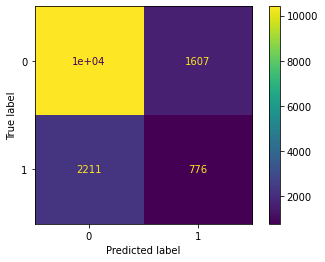

In [31]:

perceptron_model = Perceptron(tol=1e-3, random_state=0)
model_metrics(perceptron_model, X_train, X_test, y_train, y_test)

Training Time: 0.23779010772705078
validation Time: 0.06246662139892578

Accuracy: 0.7694
Precision: 0.21971496437054633
Recall: 0.061935051891529966
f1 score: 0.0966309741446853


              precision    recall  f1-score   support

           0       0.80      0.95      0.87     12013
           1       0.22      0.06      0.10      2987

    accuracy                           0.77     15000
   macro avg       0.51      0.50      0.48     15000
weighted avg       0.69      0.77      0.71     15000





BaggingClassifier(base_estimator=Perceptron(), max_features=0.5,
                  max_samples=0.5)

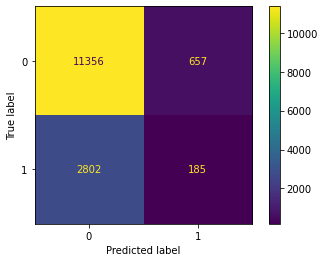

In [32]:

bagging_perceptron_model = BaggingClassifier(perceptron_model,
                            max_samples=0.5, max_features=0.5)
model_metrics(bagging_perceptron_model, X_train, X_test, y_train, y_test)

Training Time: 0.1869192123413086
validation Time: 0.0

Accuracy: 0.7474666666666666
Precision: 0.37635072553257176
Recall: 0.4081017743555407
f1 score: 0.39158368133633153


              precision    recall  f1-score   support

           0       0.85      0.83      0.84     12013
           1       0.38      0.41      0.39      2987

    accuracy                           0.75     15000
   macro avg       0.61      0.62      0.62     15000
weighted avg       0.76      0.75      0.75     15000





AdaBoostClassifier(algorithm='SAMME', base_estimator=Perceptron(),
                   random_state=0)

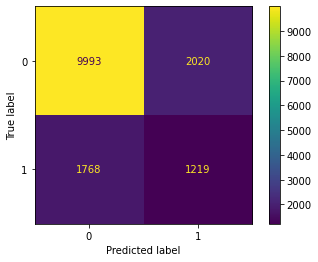

In [33]:

boost_perceptron_model = AdaBoostClassifier(base_estimator=perceptron_model, n_estimators=50, random_state=0, algorithm='SAMME')
model_metrics(boost_perceptron_model, X_train, X_test, y_train, y_test)
# requires that the weak learner supports the calculation of class probabilities

### MLP

Training Time: 8.557721376419067
validation Time: 0.0156252384185791

Accuracy: 0.9046666666666666
Precision: 0.7418452935694315
Recall: 0.7994643454971543
f1 score: 0.7695778279084755


              precision    recall  f1-score   support

           0       0.95      0.93      0.94     12013
           1       0.74      0.80      0.77      2987

    accuracy                           0.90     15000
   macro avg       0.85      0.87      0.85     15000
weighted avg       0.91      0.90      0.91     15000





MLPClassifier(max_iter=300, random_state=1)

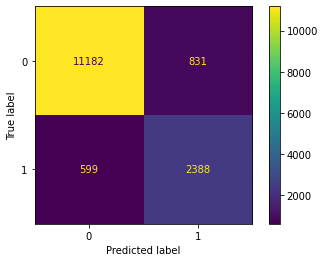

In [34]:

mlp_model = MLPClassifier(random_state=1, max_iter=300)
model_metrics(mlp_model, X_train, X_test, y_train, y_test)

Training Time: 35.94432759284973
validation Time: 0.1406419277191162

Accuracy: 0.9361333333333334
Precision: 0.9363440860215054
Recall: 0.7288249079343824
f1 score: 0.8196536144578315


              precision    recall  f1-score   support

           0       0.94      0.99      0.96     12013
           1       0.94      0.73      0.82      2987

    accuracy                           0.94     15000
   macro avg       0.94      0.86      0.89     15000
weighted avg       0.94      0.94      0.93     15000





BaggingClassifier(base_estimator=MLPClassifier(max_iter=300, random_state=1),
                  max_features=0.5, max_samples=0.5)

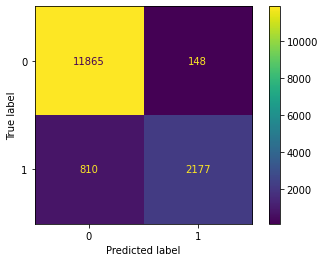

In [35]:

bagging_mlp_model = BaggingClassifier(mlp_model,
                            max_samples=0.5, max_features=0.5)
model_metrics(bagging_mlp_model, X_train, X_test, y_train, y_test)

In [36]:

xgboost_model = XGBClassifier(random_state=0) 
model_metrics(xgboost_model, X_train, X_test, y_train, y_test)

ModuleNotFoundError: No module named 'xgboost'

In [39]:
model_cat = CatBoostClassifier(verbose=0, n_estimators=1000)
model_metrics(model_cat, X_train, X_test, y_train, y_test)

NameError: name 'CatBoostClassifier' is not defined

### Stacking

Training Time: 57.895676612854004
validation Time: 10.561275482177734

Accuracy: 0.9948
Precision: 0.9837046890588627
Recall: 0.9902912621359223
f1 score: 0.986986986986987


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12013
           1       0.98      0.99      0.99      2987

    accuracy                           0.99     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       0.99      0.99      0.99     15000





StackingClassifier(estimators=[('knn', KNeighborsClassifier()),
                               ('dt', DecisionTreeClassifier()),
                               ('mlp',
                                MLPClassifier(max_iter=300, random_state=1))],
                   final_estimator=LogisticRegression())

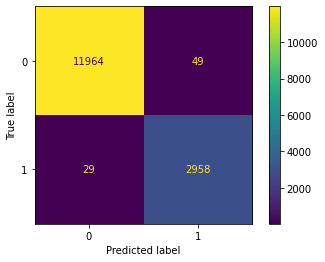

In [37]:
from sklearn.ensemble import StackingClassifier
# KNN, DT, MLP
estimators = [
    ('knn', knn_model),
    ('dt', tree_model),
    ('mlp', mlp_model)]
    
stack_knn_dt_mlp_model = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression())

model_metrics(stack_knn_dt_mlp_model, X_train, X_test, y_train, y_test)   

In [38]:

# dt, rf, cat
estimators = [
    ('dt', tree_model),
    ('rf', rf_model),
    ('cat', cat_model)]
    
stack_dt_rf_cat_model = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression())

model_metrics(stack_dt_rf_cat_model, X_train, X_test, y_train, y_test)   

NameError: name 'cat_model' is not defined

In [ ]:
from sklearn.ensemble import StackingClassifier
# rf, cat, xgboost
estimators = [
    ('rf', rf_model),
    ('cat', cat_model),
    ('xgb', xgboost_model)]
    
stack_rf_cat_xgb_model = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression())

model_metrics(stack_rf_cat_xgb_model, X_train, X_test, y_train, y_test)   

In [ ]:
from sklearn.ensemble import StackingClassifier
# rf, dt, xgboost
estimators = [
    ('rf', rf_model),
    ('dt', tree_model),
    ('xgb', xgboost_model)]
    
stack_rf_dt_xgb_model = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression())

model_metrics(stack_rf_dt_xgb_model, X_train, X_test, y_train, y_test)   

In [ ]:

# rf, dt, catboost
estimators = [
    ('rf', rf_model),
    ('dt', tree_model),
    ('cat', cat_model)]
    
stack_rf_dt_cat_model = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression())

model_metrics(stack_rf_dt_cat_model, X_train, X_test, y_train, y_test)   